In [1]:
#This is used to mount this notebook to the google drive to import dataset and model.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/ML Drive")

In [3]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Import used libraries
import nltk
import spacy
import re
import preprocessor as p
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as plx
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
#Import various layers needed for architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Loading and Reading the Dataset

Note : Because the dataset file is quite large, We have cleaned and preprocessed the raw dataset earlier and saved it as Preprocessed_Data.csv and read it for use in this notebook.

In [5]:
df = pd.read_csv('./Preprocessed_Data.csv')
df.head()

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left my ...,suicide
1,3,am i weird i don't get affected by compliments...,non-suicide
2,4,finally is almost over... so i can never hear ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"im so losthello, my name is adam (16) and ive ...",suicide


In [6]:
df['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [7]:
df['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

## Method for Text Preprocessing

- Lowercasing the texts
- Removing URLs
- Removing Hashtags
- Removing Mentions
- Removing Emojis
- Removing Smileys

The tweet-preprocessor library is used for this. (https://pypi.org/project/tweet-preprocessor)

In [31]:
def textcleaning(text):
    text = text.lower()
    text = p.clean(text)
    #Converting text to an array
    ar = []
    ar.append(text)
    return ar

In [9]:
#Changing the class labels of suicide, non-suicide to depressed, non-depressed
df = df.dropna()
df2 = df["class"].replace({"suicide": "depressed", "non-suicide":"non-depressed"})
df["class"] = df2

if "Unnamed: 0" in df.columns:
    df.drop(["Unnamed: 0"],axis=1,inplace=True)
    
df.head()

,text,class
0,ex wife threatening suiciderecently i left my ...,depressed
1,am i weird i don't get affected by compliments...,non-depressed
2,finally is almost over... so i can never hear ...,non-depressed
3,i need helpjust help me im crying so hard,depressed
4,"im so losthello, my name is adam (16) and ive ...",depressed


## Splitting the data into training and test set 

with a ratio of 8:2 with stratified sampling so ensure that the number of samples of each class are balanced in both sets

In [14]:
train_data, test_data = train_test_split(df, stratify=df["class"], test_size=0.2, random_state=69)

In [ ]:
print(train_data.shape)
print(test_data.shape)

(185626, 2)
(46407, 2)


## Data Exploration and Visualization

In [ ]:
distribution = train_data["class"].value_counts()
plx.bar(train_data,x=distribution.index.values,
        y=distribution,color=['depressed','non-depressed'])

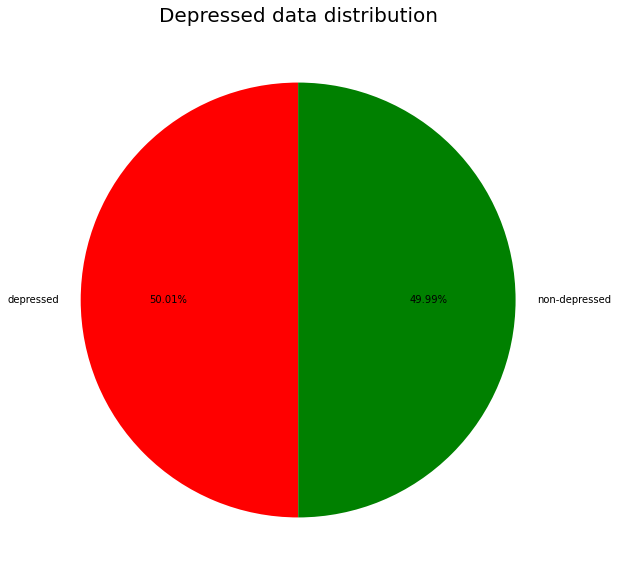

In [ ]:
plt.figure(figsize=(12,10))
plt.pie(train_data["class"].value_counts(),startangle=90,colors=['red','green'],
        autopct='%0.2f%%',labels=['depressed','non-depressed'])
plt.title('Depressed data distribution',fontdict={'size':20})
plt.show()

In [ ]:
def get_text_length(text):
    text_length=[]
    for sentence in text:
        text_length.append(len(sentence.split()))
    return text_length

In [ ]:
train_text_length = get_text_length(train_data["text"])
test_text_length = get_text_length(test_data["text"])

<Figure size 864x720 with 0 Axes>

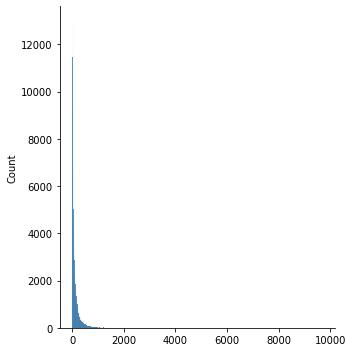

In [ ]:
#Check the distribution of each sentence length across the dataset
plt.figure(figsize=(12,10))
sns.displot(train_text_length)
plt.show()

## Tokenization

In [15]:
tokenizer = Tokenizer()
#Update the internal vocabulary accordingly
#Basically it is a word:index dictionary so that every word gets a unique integer value.
tokenizer.fit_on_texts(train_data['text'])
word_index = tokenizer.word_index

In [ ]:
i = 0
for key, value in word_index.items():
    i+=1
    print(key, ' : ', value)
    if(i==10):break

i  :  1
to  :  2
and  :  3
the  :  4
a  :  5
my  :  6
of  :  7
me  :  8
it  :  9
that  :  10


In [ ]:
#Get the vocabulary size
vocab_size = len(tokenizer.word_index)+1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 162027


In [ ]:
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns =['word','count']).sort_values(by='count', ascending=False)

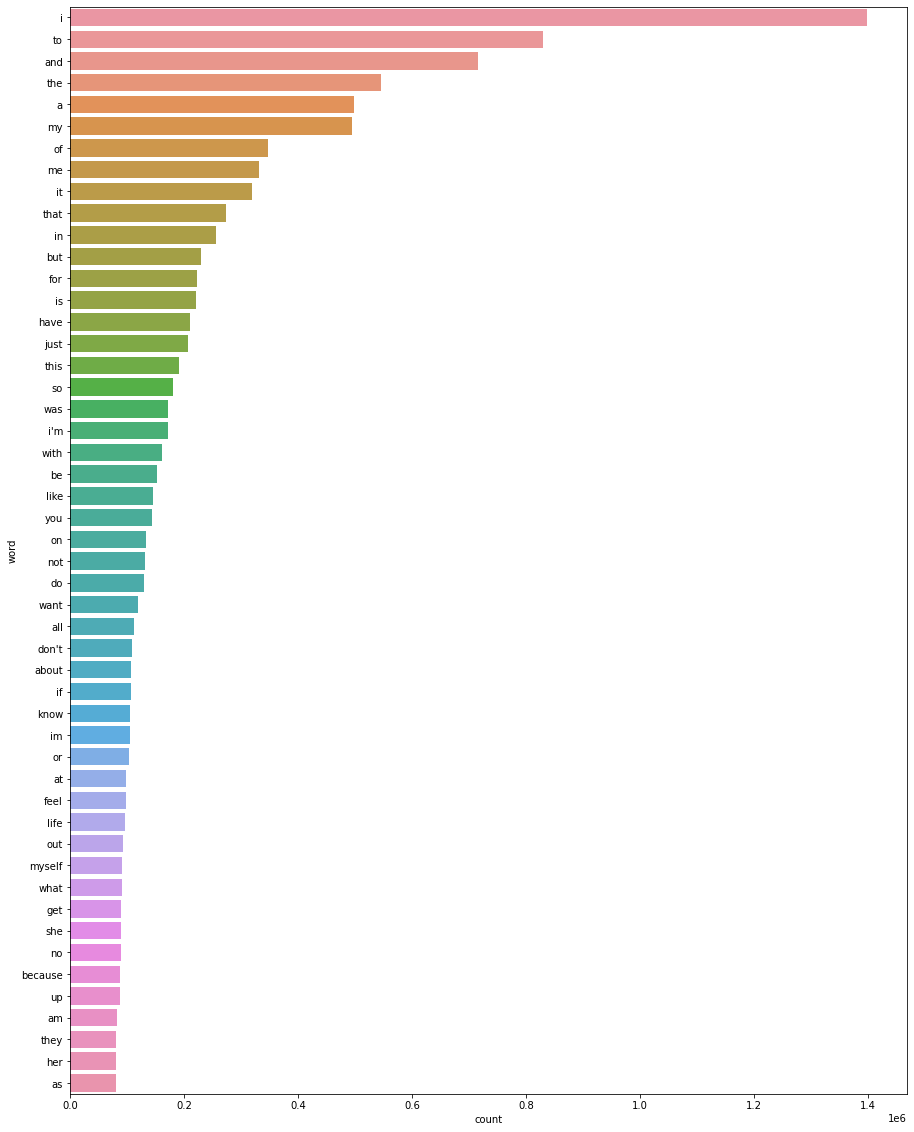

In [ ]:
#Display the top 50 most frequently appearing words in the dataset
plt.figure(figsize=(15,20))
sns.barplot(x='count', y='word', data=word_freq.iloc[:50])
plt.show()

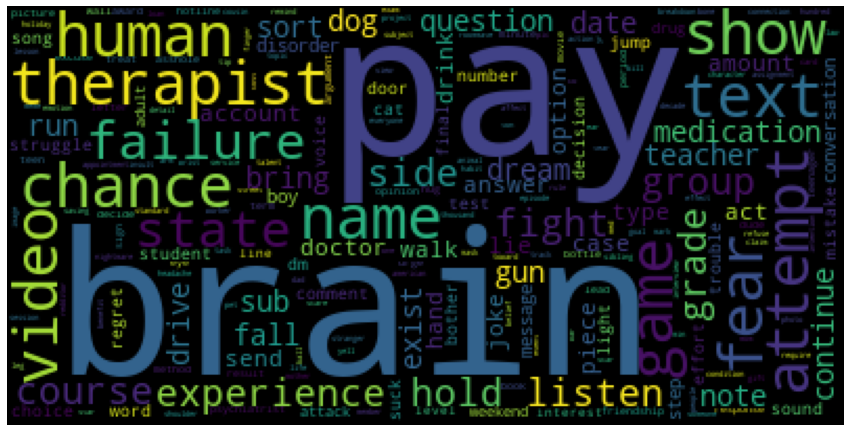

In [ ]:
#Displaying the wordcloud
feature_names = word_freq['word'].values
word_cloud = WordCloud(max_words=400)
word_cloud.generate(' '.join(word for word in feature_names[500:3500]))
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(word_cloud)

A sequence model is applied to the data. This sequence model will convert the texts to sequence. 

As we need to pass input of the same size into the model. We set the sequence length as 30 in this case

In [16]:
# The tokens are converted into sequences and then passed to the pad_sequences() function
sequence_train = tokenizer.texts_to_sequences(train_data["text"])
sequence_test = tokenizer.texts_to_sequences(test_data["text"])

x_train_pad = pad_sequences(sequence_train,maxlen = 30)
x_test_pad = pad_sequences(sequence_test,maxlen = 30)

In [ ]:
x_train_pad.shape

(185626, 30)

## Encode the labels

In [17]:
labels = ['depressed','non-depressed'] #0 for depressed, 1 for non-depressed
encoder = LabelEncoder()
encoder.fit(train_data["class"])

#The Label Encoder encode target labels with value from 0 to n-1 classes (So in this case 0-1 only because theres 2 class)
#Print all the classes available in the dataset.
print(encoder.classes_)

y_train = encoder.fit_transform(train_data["class"])
y_test = encoder.fit_transform(test_data["class"])
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

depressedcount=0
nondepressedcount=0
for i in range(len(y_train)):
    if y_train[i][0] == 0:
        depressedcount+=1
    elif y_train[i][0] == 1:
        nondepressedcount+=1

['depressed' 'non-depressed']


In [18]:
print("Depressed Count :", depressedcount)
print("Nondepressed Count :", nondepressedcount)

print("x_train shape: ",x_train_pad.shape)
print("x_test shape: ",x_test_pad.shape)
print("y_train shape:", y_train.shape)
print("y_test shape: ",y_test.shape)

Depressed Count : 92826
Nondepressed Count : 92800
x_train shape:  (185626, 30)
x_test shape:  (46407, 30)
y_train shape: (185626, 1)
y_test shape:  (46407, 1)


## GloVe Word Embeddings

Word embeddings are used to represent words with vectors. The ultimate aim is that the talks with similar meanings are closer to each other than the irrelevant words in the vector representation. The distance between the words could be measured by cosine similarity. For example, the words’ travelling’ and ‘vacation’ will be represented by vectors closer to each other.

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove.840B.300d.zip

In [ ]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('./glove.6B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


Mapping each vocab indices with glove representations

In [ ]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(162027, 300)

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=30,trainable=False)

## Building model Bi-LSTM
Model Architecture:

Embedding Layer -> Convolution Layer -> Bidirectional LSTM -> Dense Fully Connected Layer for Classification -> Sigmoid activation function before final output


In [ ]:
#The input layer with input size 30
sequence_input = Input(shape=(30,), dtype='int32')
#Inputs passed to embedding layer
embedding_sequences = embedding_layer(sequence_input)
#Dropout and Convolution Layer
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
#Passed on to LSTM layer
x = Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
#Passed on to activation layer to get final output
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           48608100  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

## Training the Model

- Optimizer used = ADAM

- Loss function = Binary Classification (Binary Cross Entropy loss)

- Generally, it is helpful to alter the learning rate during the training for minor dataset training problems. For this, we used one of the Learning rate Schedulers. The ReduceLROnPLateau will decrease the learning rate by a factor of 0.1 (can be specified) if the validation loss is not falling. Here, the monitor used in ReduceOnPlateau is the validation loss. 

- EarlyStopping is also used to stop training when a monitored metric has stopped improving. In our case, if the validation loss does not improve after 3 epochs, then stop the training and save the best weights.

- Checkpoint is applied in case we want to retrain the model at another time.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)

EarlyStopping = EarlyStopping(monitor='val_loss',
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

checkpoint_filepath='/tmp/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='loss', save_best_only=True, mode='auto')

callbacks_list = [ReduceLROnPlateau,EarlyStopping,checkpoint]

Training Parameters:

- minibatch size is set to 512
- 10 epochs is chosen

In [ ]:
training = model.fit(x_train_pad, y_train, batch_size=512, epochs=10, validation_data=(x_test_pad, y_test), callbacks=callbacks_list)

Epoch 1/10
363/363 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8318INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 125s 299ms/step - loss: 0.3786 - accuracy: 0.8318 - val_loss: 0.3012 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 2/10
363/363 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8704INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 106s 292ms/step - loss: 0.3082 - accuracy: 0.8704 - val_loss: 0.2869 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 3/10
363/363 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.8812INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 106s 293ms/step - loss: 0.2854 - accuracy: 0.8812 - val_loss: 0.2746 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 4/10
363/363 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.8888INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 104s 286ms/step - loss: 0.2712 - accuracy: 0.8888 - val_loss: 0.2729 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 5/10
363/363 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8922INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 105s 288ms/step - loss: 0.2628 - accuracy: 0.8922 - val_loss: 0.2901 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 6/10
363/363 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.8969INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 107s 296ms/step - loss: 0.2541 - accuracy: 0.8969 - val_loss: 0.2761 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 7/10
363/363 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.8994INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 106s 291ms/step - loss: 0.2466 - accuracy: 0.8994 - val_loss: 0.2622 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 8/10
363/363 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9026INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 103s 284ms/step - loss: 0.2408 - accuracy: 0.9026 - val_loss: 0.2621 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 9/10
363/363 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9043INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 107s 295ms/step - loss: 0.2356 - accuracy: 0.9043 - val_loss: 0.2727 - val_accuracy: 0.8930 - lr: 0.0010
Epoch 10/10
363/363 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9071INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


363/363 [==============================] - 104s 285ms/step - loss: 0.2293 - accuracy: 0.9071 - val_loss: 0.2646 - val_accuracy: 0.8943 - lr: 0.0010


### Save the model and weights

In [ ]:
model.save("depressed_detection_model_final.h5")

In [ ]:
from google.colab import files
files.download('depressed_detection_model_final.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from keras.models import load_model
new_model = load_model('depressed_detection_model_final.h5')

In [19]:
loss, acc = new_model.evaluate(x_test_pad, y_test, verbose=1)

1451/1451 [==============================] - 35s 17ms/step - loss: 0.2646 - accuracy: 0.8943


# Plotting the Loss and Accuracy Graph

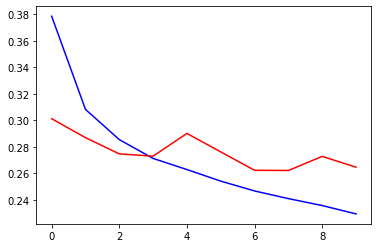

In [ ]:
plt.plot(training.history['loss'], color = "blue")
plt.plot(training.history['val_loss'], color = "red")
plt.show()

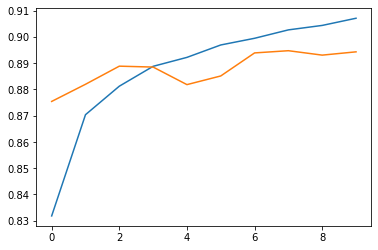

In [ ]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.show()

## Model evaluation

In [20]:
def predict_sentence_depression(score):
  return "non-depressed" if score>0.5 else "depressed"

In [24]:
prediction = new_model.predict(x_test_pad,verbose=1, batch_size=10000)
model_predictions = [predict_sentence_depression(predict) for predict in prediction]

5/5 [==============================] - 1s 93ms/step


In [22]:
y_test2 = encoder.inverse_transform(y_test)
y_test2.shape

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(46407,)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test2,model_predictions))

               precision    recall  f1-score   support

    depressed       0.90      0.89      0.89     23207
non-depressed       0.89      0.90      0.89     23200

     accuracy                           0.89     46407
    macro avg       0.89      0.89      0.89     46407
 weighted avg       0.89      0.89      0.89     46407



In [27]:
#This is just an external method used to display the confusion matrix in a neater way
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [26]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_test2, model_predictions)
print(cm)

[[20719  2488]
 [ 2418 20782]]


None


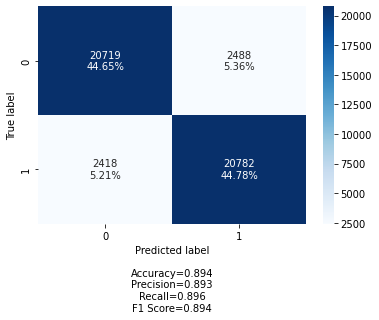

In [28]:
print(make_confusion_matrix(cm))

## Testing the model with user input text

In [29]:
ayat = "i want to drink water"

In [32]:
cleanedayat = textcleaning(ayat)
cleanedayat

['i want to drink water']

Padding

In [33]:
sequence_ayat = tokenizer.texts_to_sequences(cleanedayat)
x_ayat_pad = pad_sequences(sequence_ayat,maxlen = 30)

In [34]:
x_ayat_pad.shape

(1, 30)

In [35]:
prr = new_model.predict(x_ayat_pad, verbose=1)
prr.shape

1/1 [==============================] - 0s 147ms/step


(1, 1)

In [36]:
predict_sentence_depression(prr)

'non-depressed'